In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import os
import random
import cv2
import ultralytics

import tensorflow as tf
from ultralytics import YOLO
from PIL import Image
import yaml
from collections import defaultdict

import albumentations as A
import shutil
from tqdm import tqdm

In [2]:
import torch

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
dir = "G:/My Drive/UAO/7° Semestre/IA Embebidos/proyecto_3/Trash"

In [5]:
with open(os.path.join(dir, "data.yaml"), 'r') as f:
  data_yaml = yaml.safe_load(f)
  class_names = data_yaml['names']
  num_classes = len(class_names)

In [6]:
print(class_names)
print(num_classes)

['Bateria', 'BotellaPlastico', 'BotellaVidrio', 'HojaPapel', 'TapaPlastico', 'TazaPapel']
6


## Lectura y validación de imágenes con su máscara 

In [16]:
def show_image_with_boxes(img_path, label_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w = img.shape[:2]

  fig, ax = plt.subplots(1)
  ax.imshow(img)

  with open(label_path, 'r') as f:
    for line in f.readlines():
      cls_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
      x_center *= w
      y_center *= h
      box_w *= w
      box_h *= h
      x1 = x_center - box_w / 2
      y1 = y_center - box_h / 2
      rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.text(x1, y1 - 10, class_names[int(cls_id)],
              color='white', backgroundcolor='red', fontsize=8)
  plt.axis('off')
  plt.show()

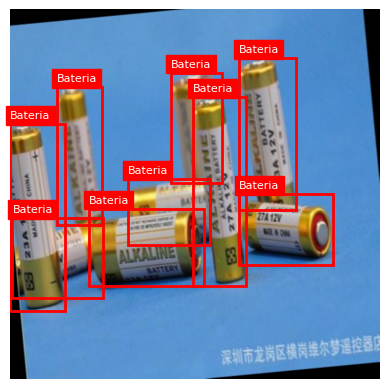

In [17]:
subsets = ['train', 'valid', 'test']

subset = subsets[0]
images_dir = os.path.join(dir, subset, 'images')
labels_dir = os.path.join(dir, subset, 'labels')

random_image = random.choice(os.listdir(images_dir))
img_path = os.path.join(images_dir, random_image)
label_path = os.path.join(labels_dir, random_image.replace('.jpg', '.txt').replace('.png', '.txt'))

show_image_with_boxes(img_path, label_path)

In [18]:
def count_boxes_per_class(base_path, sets):
  stats = {}

  for s in sets:
    labels_dir = os.path.join(base_path, s, 'labels')
    class_counts = defaultdict(int)

    for label_file in os.listdir(labels_dir):
      with open(os.path.join(labels_dir, label_file), 'r') as f:
        for line in f:
          cls_id = int(float(line.strip().split()[0]))
          class_counts[cls_id] += 1

    stats[s] = {class_names[k]: v for k, v in class_counts.items()}
  return stats

## Entrenamiento de modelo

In [19]:
model = YOLO('yolov8n.pt')

In [20]:
model.train(
  data= dir + '/data.yaml',
  epochs=150,
  imgsz=640,
  batch=32,
  workers=2,
  name='trash_yolov8n_640_v2',
  device=0  # Usa 'cpu' o '0' para GPU
)

New https://pypi.org/project/ultralytics/8.3.144 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=G:/My Drive/UAO/7 Semestre/IA Embebidos/proyecto_3/Trash/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals

train: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\train\labels.cache... 6392 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6392/6392 [00:00<?, ?it/s]

train: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\train\images\train_Image_93_png.rf.5e12f3faf71db62a649aa4d738d1a07f.jpg: 1 duplicate labels removed
train: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\train\images\train_Image_93_png.rf.e61c4247ceaaab2f5d286fc013c3abf6.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 1.00.1 ms, read: 6.63.6 MB/s, size: 65.1 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1825 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1825/1825 [00:00<?, ?it/s]

val: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\valid\images\train_Image_93_png.rf.a9258ae990417389e348cc58616e37cf.jpg: 1 duplicate labels removed


Plotting labels to runs\detect\trash_yolov8n_640_v2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\trash_yolov8n_640_v2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.92G       1.22      2.999       1.37         93        640: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.99it/s]


                   all       1825       6011      0.448      0.487      0.425      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.52G      1.222      1.922       1.33        113        640: 100%|██████████| 200/200 [01:30<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


                   all       1825       6011      0.513      0.504      0.485      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      5.24G      1.298       1.87      1.371        159        640: 100%|██████████| 200/200 [01:29<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


                   all       1825       6011       0.49      0.393      0.367      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.29G      1.398      1.919      1.443        150        640: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


                   all       1825       6011      0.441       0.42      0.386      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.58G      1.368      1.762       1.42        115        640: 100%|██████████| 200/200 [01:27<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.86it/s]


                   all       1825       6011       0.52      0.503      0.485      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.42G       1.34      1.619      1.392        115        640: 100%|██████████| 200/200 [01:29<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


                   all       1825       6011      0.576      0.526      0.525      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      5.18G      1.294       1.51      1.366        160        640: 100%|██████████| 200/200 [01:29<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.08it/s]


                   all       1825       6011      0.528      0.465      0.457      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.84G      1.268      1.423      1.346        100        640: 100%|██████████| 200/200 [01:29<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.11it/s]


                   all       1825       6011      0.625      0.606      0.627      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.94G      1.244      1.368      1.337        124        640: 100%|██████████| 200/200 [01:31<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]

                   all       1825       6011       0.69      0.639      0.667      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      5.97G      1.234      1.338      1.329        111        640: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.13it/s]

                   all       1825       6011      0.634      0.677      0.689      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       5.8G      1.201      1.249      1.302        112        640: 100%|██████████| 200/200 [01:26<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:21<00:00,  1.36it/s]

                   all       1825       6011      0.655      0.668      0.699      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.33G      1.204      1.228      1.296        150        640: 100%|██████████| 200/200 [01:29<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1825       6011      0.712      0.689      0.719      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      5.19G      1.182      1.195      1.279        149        640: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1825       6011      0.646      0.743      0.729      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      6.21G      1.162      1.153      1.275        147        640: 100%|██████████| 200/200 [01:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.02it/s]

                   all       1825       6011      0.716      0.699      0.734      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      5.52G       1.16      1.142      1.275         64        640: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1825       6011      0.705      0.738      0.739      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.49G      1.138      1.107       1.26        178        640: 100%|██████████| 200/200 [01:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1825       6011      0.711      0.749      0.753      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       5.6G      1.128      1.078      1.246        133        640: 100%|██████████| 200/200 [01:27<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1825       6011      0.698       0.71      0.749      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      6.49G      1.124      1.081      1.246        106        640: 100%|██████████| 200/200 [01:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.82it/s]

                   all       1825       6011      0.749      0.765      0.792      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.92G      1.109      1.042      1.241        121        640: 100%|██████████| 200/200 [01:28<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1825       6011      0.759      0.778      0.801      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      5.03G      1.108      1.035      1.243        151        640: 100%|██████████| 200/200 [01:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1825       6011       0.75      0.748      0.778      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      5.15G        1.1      1.025      1.236        149        640: 100%|██████████| 200/200 [01:27<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all       1825       6011      0.726      0.747      0.775      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.59G      1.086      1.002       1.23        173        640: 100%|██████████| 200/200 [01:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

                   all       1825       6011      0.744      0.788       0.81      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      5.94G       1.08     0.9787      1.216        143        640: 100%|██████████| 200/200 [01:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all       1825       6011      0.746      0.791      0.793      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      6.06G       1.06     0.9668      1.211        105        640: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:18<00:00,  1.59it/s]

                   all       1825       6011      0.756      0.779      0.801      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150         5G      1.063     0.9706      1.207        116        640: 100%|██████████| 200/200 [01:27<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all       1825       6011      0.773      0.793      0.808      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      5.99G      1.046     0.9506      1.203        135        640: 100%|██████████| 200/200 [01:29<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all       1825       6011      0.766      0.791      0.804       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.98G      1.052     0.9483      1.206        135        640: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1825       6011      0.773      0.793      0.815      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      6.27G      1.052     0.9208        1.2        209        640: 100%|██████████| 200/200 [01:27<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.98it/s]

                   all       1825       6011      0.786      0.788      0.824      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150       5.6G      1.037     0.9105      1.195        222        640: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.93it/s]

                   all       1825       6011      0.775      0.824      0.829      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150       5.6G      1.024     0.9049       1.19        117        640: 100%|██████████| 200/200 [01:27<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1825       6011      0.773      0.806      0.814      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150       6.1G      1.023      0.897      1.186        142        640: 100%|██████████| 200/200 [01:29<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.16it/s]

                   all       1825       6011      0.792      0.842      0.846      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.59G      1.015     0.8822      1.179         91        640: 100%|██████████| 200/200 [01:28<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all       1825       6011      0.787      0.837      0.841      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      5.11G      1.004      0.876      1.176        172        640: 100%|██████████| 200/200 [01:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all       1825       6011      0.786      0.832      0.848      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      5.56G      1.009     0.8682      1.177        185        640: 100%|██████████| 200/200 [01:30<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.03it/s]

                   all       1825       6011      0.782      0.847      0.838      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.19G      1.012     0.8734      1.178        150        640: 100%|██████████| 200/200 [01:37<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]

                   all       1825       6011      0.791      0.837      0.844      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.69G     0.9982     0.8557      1.168        135        640: 100%|██████████| 200/200 [01:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all       1825       6011      0.789      0.841      0.843      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.42G          1     0.8522      1.169        154        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.56it/s]

                   all       1825       6011      0.812      0.827      0.848      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      5.52G     0.9902     0.8432      1.162        221        640: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.60it/s]

                   all       1825       6011      0.805      0.853      0.851      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.67G     0.9865     0.8339      1.158         88        640: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.812      0.843      0.854       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.37G     0.9826     0.8237      1.156        131        640: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


                   all       1825       6011      0.813      0.859      0.865      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      5.25G     0.9722     0.8086      1.148        115        640: 100%|██████████| 200/200 [11:20<00:00,  3.40s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.14it/s]

                   all       1825       6011      0.807      0.849      0.863      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      5.97G     0.9735     0.8146      1.156        113        640: 100%|██████████| 200/200 [01:29<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.17it/s]

                   all       1825       6011      0.794      0.842      0.847      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      5.61G     0.9716      0.815      1.152        158        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


                   all       1825       6011      0.806      0.863      0.865      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.69G     0.9742     0.8023      1.153        110        640: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.817      0.849      0.864       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      5.43G     0.9645     0.8109      1.148        134        640: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


                   all       1825       6011      0.815      0.861      0.869      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      5.33G     0.9531     0.7845      1.143        133        640: 100%|██████████| 200/200 [01:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all       1825       6011      0.819      0.861      0.863      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      5.22G     0.9433     0.7743      1.134        169        640: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.818      0.863      0.869       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.96G     0.9514      0.781      1.145        105        640: 100%|██████████| 200/200 [01:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.60it/s]

                   all       1825       6011      0.814      0.866      0.868      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      5.37G     0.9445     0.7714      1.133        108        640: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.798      0.859      0.849      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150         6G     0.9451      0.778      1.132        161        640: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011       0.82      0.862      0.866      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      5.45G     0.9497     0.7747      1.134        116        640: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.58it/s]

                   all       1825       6011      0.828      0.859      0.865      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      5.15G     0.9329     0.7618      1.126        148        640: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.58it/s]

                   all       1825       6011      0.804      0.869      0.865      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      6.54G     0.9417     0.7604      1.137        182        640: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


                   all       1825       6011      0.825      0.866       0.87      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150       5.5G     0.9238     0.7469      1.122        129        640: 100%|██████████| 200/200 [01:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]

                   all       1825       6011      0.825      0.881      0.871      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      5.68G     0.9219     0.7369      1.122        228        640: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.01it/s]

                   all       1825       6011      0.833      0.873      0.875      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      5.84G     0.9148      0.741      1.118        118        640: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  1.97it/s]

                   all       1825       6011      0.829      0.869      0.874      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      5.46G     0.9235     0.7376      1.123        138        640: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.60it/s]

                   all       1825       6011      0.838      0.866      0.883      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.92G     0.9259     0.7405      1.124        150        640: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.828      0.882      0.881      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      5.48G     0.9078     0.7172      1.109        179        640: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all       1825       6011      0.825      0.876      0.879      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      5.09G     0.9147     0.7352       1.12        116        640: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.40it/s]

                   all       1825       6011       0.83      0.882      0.883      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      5.92G     0.9006     0.7178      1.109        132        640: 100%|██████████| 200/200 [01:14<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.841      0.871      0.881      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      5.76G     0.9037     0.7215      1.111        174        640: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]

                   all       1825       6011      0.832      0.889      0.885      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      6.82G     0.9012     0.7143      1.104        104        640: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.73it/s]

                   all       1825       6011       0.84      0.878      0.884      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      5.77G     0.8957     0.7117      1.108        195        640: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]

                   all       1825       6011      0.842      0.874      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      5.59G     0.8986     0.7163      1.108        132        640: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.836      0.877      0.887      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      5.28G     0.8985     0.7004      1.108        156        640: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.58it/s]

                   all       1825       6011      0.845       0.88      0.882      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.92G     0.8961      0.704      1.107        254        640: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.66it/s]

                   all       1825       6011      0.853      0.875      0.891      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150       5.2G     0.8849     0.7021      1.105        104        640: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.59it/s]

                   all       1825       6011       0.85      0.881      0.888      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      5.12G     0.8787     0.6909      1.098        105        640: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.835      0.886      0.884      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      5.02G     0.8795     0.6907        1.1        235        640: 100%|██████████| 200/200 [01:13<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.58it/s]

                   all       1825       6011      0.838      0.889      0.888      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      6.12G     0.8841     0.6923        1.1        138        640: 100%|██████████| 200/200 [01:21<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all       1825       6011      0.851      0.885      0.885       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      5.12G     0.8685     0.6808      1.097         92        640: 100%|██████████| 200/200 [01:19<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.47it/s]

                   all       1825       6011      0.844      0.891       0.89      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      5.85G     0.8812     0.6894        1.1        105        640: 100%|██████████| 200/200 [01:35<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.851      0.884      0.889       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      6.12G     0.8786      0.683      1.095        120        640: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all       1825       6011      0.848      0.887      0.885      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.83G     0.8676     0.6657      1.088        283        640: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all       1825       6011      0.847      0.896      0.888      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      5.93G     0.8697     0.6711      1.094        146        640: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.849      0.893       0.89      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      5.51G     0.8729     0.6679      1.089        296        640: 100%|██████████| 200/200 [01:14<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.69it/s]

                   all       1825       6011      0.845      0.893      0.891      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      5.51G     0.8576     0.6662      1.085        135        640: 100%|██████████| 200/200 [01:24<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


                   all       1825       6011      0.858      0.877      0.887      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      5.38G      0.869     0.6675      1.091        121        640: 100%|██████████| 200/200 [04:58<00:00,  1.49s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]

                   all       1825       6011      0.851      0.884      0.888      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      5.52G     0.8569     0.6596      1.083        139        640: 100%|██████████| 200/200 [01:52<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.30it/s]

                   all       1825       6011      0.846      0.894      0.892      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.89G     0.8493     0.6502      1.079        130        640: 100%|██████████| 200/200 [01:39<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.847      0.888      0.889      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      5.44G     0.8551      0.652       1.08        156        640: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all       1825       6011      0.847      0.892      0.889      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      5.24G     0.8539      0.654      1.087        236        640: 100%|██████████| 200/200 [01:16<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]

                   all       1825       6011       0.85       0.89      0.888      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.83G     0.8469     0.6463      1.079        114        640: 100%|██████████| 200/200 [01:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.62it/s]

                   all       1825       6011      0.843      0.892      0.886      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.96G     0.8373     0.6455      1.074        139        640: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.845      0.892       0.89      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      5.33G     0.8408     0.6453      1.075        156        640: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.23it/s]

                   all       1825       6011      0.848       0.89       0.89      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.82G     0.8472     0.6444      1.079        105        640: 100%|██████████| 200/200 [01:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.852      0.895      0.893      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.01G     0.8339     0.6409      1.073        103        640: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.853      0.891      0.894      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      5.38G     0.8424     0.6404      1.075        127        640: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.36it/s]

                   all       1825       6011      0.843      0.895      0.893      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.15G     0.8293     0.6359      1.076        109        640: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.853      0.892      0.893      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.58G     0.8244     0.6262      1.071        121        640: 100%|██████████| 200/200 [01:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.10it/s]

                   all       1825       6011      0.859      0.887      0.892      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      5.31G     0.8304     0.6294      1.078        154        640: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]

                   all       1825       6011      0.858       0.89      0.895      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      5.22G     0.8323     0.6179      1.065        176        640: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.60it/s]

                   all       1825       6011      0.851      0.896      0.894      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150         6G     0.8165      0.615       1.06        191        640: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]

                   all       1825       6011      0.847      0.903      0.894      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      4.82G     0.8291     0.6207       1.07        193        640: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.849      0.898      0.896      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.16G     0.8168     0.6149      1.065        100        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.56it/s]

                   all       1825       6011      0.858      0.892      0.895      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.51G     0.8174     0.6214      1.069        206        640: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.48it/s]

                   all       1825       6011      0.849        0.9      0.894       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.65G     0.8182     0.6163      1.061        152        640: 100%|██████████| 200/200 [01:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.845      0.904      0.894      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       4.7G     0.8151     0.6096       1.06        174        640: 100%|██████████| 200/200 [01:18<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.48it/s]

                   all       1825       6011      0.848      0.902      0.895      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      4.84G     0.8108     0.6091      1.063         78        640: 100%|██████████| 200/200 [01:18<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]

                   all       1825       6011      0.847      0.904      0.893      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      5.39G      0.808     0.5981      1.062        190        640: 100%|██████████| 200/200 [01:22<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.41it/s]

                   all       1825       6011      0.851      0.897      0.893      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      4.83G     0.8013      0.607      1.057        131        640: 100%|██████████| 200/200 [01:17<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.856      0.895      0.893      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      4.94G     0.7948     0.6041      1.058        120        640: 100%|██████████| 200/200 [01:16<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.854      0.897      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      5.36G     0.7885     0.5964      1.053        156        640: 100%|██████████| 200/200 [01:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.851        0.9      0.893      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      5.01G     0.7923      0.593      1.054        151        640: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.855      0.897      0.895      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      5.02G      0.798     0.5912      1.054        108        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]

                   all       1825       6011      0.853        0.9      0.894      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      5.51G     0.7927     0.5964      1.055        177        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all       1825       6011       0.85      0.904      0.894      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      5.16G     0.7928     0.5876      1.048        117        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.853        0.9      0.894      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      4.98G     0.7844     0.5869      1.052        180        640: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011       0.85      0.901      0.894      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      5.97G     0.7935     0.5847      1.049        165        640: 100%|██████████| 200/200 [01:21<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.854      0.901      0.893      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      6.13G     0.7756     0.5818      1.045        158        640: 100%|██████████| 200/200 [01:21<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all       1825       6011      0.857      0.896      0.891      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      5.12G     0.7787       0.58      1.046        112        640: 100%|██████████| 200/200 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]

                   all       1825       6011      0.856      0.897      0.891      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      5.42G      0.783      0.583      1.048        148        640: 100%|██████████| 200/200 [01:17<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.851      0.902       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      5.87G     0.7816     0.5806      1.047         97        640: 100%|██████████| 200/200 [01:16<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.58it/s]

                   all       1825       6011      0.852      0.902      0.889      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      5.73G     0.7769     0.5729      1.046        118        640: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.852      0.902       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150         5G     0.7603     0.5589      1.036        124        640: 100%|██████████| 200/200 [01:23<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.60it/s]

                   all       1825       6011      0.854      0.903      0.889      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      5.28G     0.7671     0.5638      1.036        223        640: 100%|██████████| 200/200 [01:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.853      0.902       0.89      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      5.46G     0.7661     0.5588      1.038        123        640: 100%|██████████| 200/200 [01:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.852      0.905       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      4.82G     0.7624     0.5574      1.036        126        640: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.855      0.901       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      5.31G     0.7574     0.5532      1.029        159        640: 100%|██████████| 200/200 [01:19<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all       1825       6011      0.854      0.902      0.889      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      5.51G     0.7622      0.562      1.034        247        640: 100%|██████████| 200/200 [01:20<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all       1825       6011      0.856      0.901      0.889      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      4.93G     0.7522     0.5494      1.036        129        640: 100%|██████████| 200/200 [01:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.854      0.902      0.889      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      4.75G     0.7555     0.5562       1.03        134        640: 100%|██████████| 200/200 [01:22<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.852      0.904      0.889      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      5.26G     0.7459     0.5471      1.027        158        640: 100%|██████████| 200/200 [01:19<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all       1825       6011      0.851      0.906      0.888      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       4.7G     0.7631      0.562      1.035         87        640: 100%|██████████| 200/200 [01:19<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.56it/s]

                   all       1825       6011      0.857      0.899      0.888      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      5.71G     0.7518     0.5471      1.034        146        640: 100%|██████████| 200/200 [01:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.59it/s]

                   all       1825       6011      0.854      0.901      0.889      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      4.77G     0.7499     0.5497      1.033        144        640: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.854      0.903      0.889      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      5.16G     0.7422     0.5429      1.029        104        640: 100%|██████████| 200/200 [01:19<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all       1825       6011      0.854      0.904      0.889      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      4.98G      0.745     0.5363      1.024        183        640: 100%|██████████| 200/200 [01:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all       1825       6011      0.855      0.902      0.889      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      4.88G     0.7376     0.5392      1.024        111        640: 100%|██████████| 200/200 [01:21<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.857      0.901      0.889      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      5.03G     0.7335     0.5381      1.027        161        640: 100%|██████████| 200/200 [01:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.65it/s]

                   all       1825       6011      0.856      0.901      0.888      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      5.44G     0.7373     0.5377      1.026        137        640: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.856      0.901      0.888      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      5.14G     0.7379      0.535      1.024        195        640: 100%|██████████| 200/200 [01:17<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.60it/s]

                   all       1825       6011      0.855      0.901      0.888      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       5.6G     0.7378       0.53      1.026        149        640: 100%|██████████| 200/200 [01:13<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all       1825       6011      0.855      0.901      0.888      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      5.33G     0.7274     0.5303      1.021        140        640: 100%|██████████| 200/200 [01:14<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.49it/s]

                   all       1825       6011      0.854      0.901      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      5.25G     0.7212     0.5241      1.017        108        640: 100%|██████████| 200/200 [01:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.62it/s]

                   all       1825       6011      0.853        0.9      0.889      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.75G     0.7243     0.5267       1.02        151        640: 100%|██████████| 200/200 [01:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all       1825       6011      0.853      0.901      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.87G       0.72     0.5214      1.021        210        640: 100%|██████████| 200/200 [01:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all       1825       6011      0.854      0.898      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      5.16G     0.7243     0.5245       1.02        188        640: 100%|██████████| 200/200 [01:13<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.855      0.897      0.888      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      5.39G     0.7101     0.5166      1.015        256        640: 100%|██████████| 200/200 [01:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all       1825       6011      0.855      0.899      0.888      0.717


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.51G     0.6576      0.448     0.9814         54        640: 100%|██████████| 200/200 [01:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.56it/s]

                   all       1825       6011      0.853      0.901      0.888      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150       4.7G     0.6442      0.438     0.9788         69        640: 100%|██████████| 200/200 [01:08<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all       1825       6011      0.854        0.9      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.86G     0.6388     0.4335     0.9767        153        640: 100%|██████████| 200/200 [01:10<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.855      0.899      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150       4.5G     0.6318     0.4248     0.9692        145        640: 100%|██████████| 200/200 [01:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all       1825       6011      0.856      0.898      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      4.27G     0.6304     0.4273     0.9703        180        640: 100%|██████████| 200/200 [01:09<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all       1825       6011      0.856      0.897      0.888      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      5.11G     0.6216     0.4196     0.9655         59        640: 100%|██████████| 200/200 [01:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.39it/s]

                   all       1825       6011      0.857      0.897      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      4.53G     0.6259     0.4209     0.9696         42        640: 100%|██████████| 200/200 [01:22<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.48it/s]

                   all       1825       6011      0.857      0.897      0.888      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      4.46G     0.6159     0.4133     0.9617         66        640: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.35it/s]

                   all       1825       6011      0.857      0.897      0.888      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      4.76G      0.612     0.4085      0.963        156        640: 100%|██████████| 200/200 [01:19<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.05it/s]

                   all       1825       6011      0.856      0.898      0.887      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      4.95G     0.6127     0.4127     0.9613         44        640: 100%|██████████| 200/200 [01:10<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all       1825       6011      0.858      0.896      0.887      0.719



150 epochs completed in 4.110 hours.
Optimizer stripped from runs\detect\trash_yolov8n_640_v2\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\trash_yolov8n_640_v2\weights\best.pt, 6.3MB

Validating runs\detect\trash_yolov8n_640_v2\weights\best.pt...
Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


                   all       1825       6011      0.858      0.896      0.887      0.719
               Bateria        193        997      0.964      0.986      0.991      0.816
       BotellaPlastico        315       1007      0.761      0.848      0.797      0.651
         BotellaVidrio        335       1000      0.847      0.928      0.906       0.77
             HojaPapel        734       1016      0.987      0.963      0.987      0.844
          TapaPlastico        318       1047       0.71      0.818      0.778       0.59
             TazaPapel        134        944      0.878      0.836      0.866      0.643
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\trash_yolov8n_640_v2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002458806B760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [21]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.80.1 ms, read: 7.15.5 MB/s, size: 50.6 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\valid\labels.cache... 1825 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1825/1825 [00:00<?, ?it/s]

val: G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\valid\images\train_Image_93_png.rf.a9258ae990417389e348cc58616e37cf.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:14<00:00,  4.01it/s]


                   all       1825       6011      0.858      0.896      0.887      0.719
               Bateria        193        997      0.964      0.986      0.991      0.819
       BotellaPlastico        315       1007       0.76      0.848      0.796      0.651
         BotellaVidrio        335       1000      0.847      0.928      0.906      0.771
             HojaPapel        734       1016      0.987      0.963      0.987      0.844
          TapaPlastico        318       1047      0.711      0.818      0.778       0.59
             TazaPapel        134        944      0.877      0.835      0.866      0.641
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\trash_yolov8n_640_v22
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002456D3B82B0>
curv

In [22]:
model.save("Model/trash_yolov8n_640_v2.pt")

In [23]:
results = model.val(
  data=dir + "/data.yaml",
  split='test',
  imgsz=640,
  batch=32,
  project=dir + '/resultados',
  name='val_trash_yolov8n_640_v2',
  exist_ok=True
)

Ultralytics 8.3.141  Python-3.10.16 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Fast image access  (ping: 0.90.1 ms, read: 4.02.2 MB/s, size: 44.2 KB)


val: Scanning G:\My Drive\UAO\7° Semestre\IA Embebidos\proyecto_3\Trash\test\labels.cache... 918 images, 0 backgrounds, 0 corrupt: 100%|██████████| 918/918 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.89it/s]


                   all        918       2881      0.821      0.891      0.852      0.696
               Bateria         98        428      0.957      0.981       0.99       0.82
       BotellaPlastico        155        472      0.752      0.874      0.791      0.665
         BotellaVidrio        170        476      0.822      0.943      0.938      0.801
             HojaPapel        367        470      0.993      0.998      0.995      0.852
          TapaPlastico        164        448       0.69      0.835      0.708       0.51
             TazaPapel         67        587      0.714      0.714      0.693      0.526
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to G:\My Drive\UAO\7 Semestre\IA Embebidos\proyecto_3\Trash\resultados\val_trash_yolov8n_640_v2
